Handling PII Data
To protect personally identifiable information (PII):

- Credit Card Numbers were securely hashed using SHA-256.

- Full Names were parsed into first and last names using regex to reduce exposure.

These steps balance data utility and user privacy in accordance with best practices.

Data Quality Assurance
To ensure clean and reliable data:

- Null Values were detected using isNull() checks and handled based on context.

- Inconsistent name formats were cleaned using regex to extract valid name parts.

- Nested JSON Fields (e.g., personal_detail, address) were flattened for easier analysis.

- Timestamps were normalized to UTC+8 with consistent formatting.

- Data Types (like amt) were cast correctly from string to float.

These transformations addressed common data issues and improved downstream analysis.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import *
from pyspark.sql.functions import regexp_extract, trim
from pyspark.sql.functions import to_timestamp, from_utc_timestamp, date_format
from pyspark.sql.functions import col
from pyspark.sql.functions import col, count, when

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import to_timestamp, date_format

In [2]:
spark = SparkSession.builder.appName("CreditCardAnalysis").getOrCreate()

df_raw = spark.read.text("cc_sample_transaction.json")
df_raw.show(10)

25/04/17 00:27:31 WARN Utils: Your hostname, Mohammads-MacBook-Air-2.local resolves to a loopback address: 127.0.0.1; using 192.168.0.184 instead (on interface en0)
25/04/17 00:27:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/17 00:27:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------------------+
|               value|
+--------------------+
|{"Unnamed: 0":"0"...|
|{"Unnamed: 0":"1"...|
|{"Unnamed: 0":"2"...|
|{"Unnamed: 0":"3"...|
|{"Unnamed: 0":"4"...|
|{"Unnamed: 0":"5"...|
|{"Unnamed: 0":"6"...|
|{"Unnamed: 0":"7"...|
|{"Unnamed: 0":"8"...|
|{"Unnamed: 0":"9"...|
+--------------------+
only showing top 10 rows



In [3]:
schema = StructType([
    StructField("Unnamed: 0", StringType()),
    StructField("trans_date_trans_time", StringType()),
    StructField("cc_bic", StringType()),
    StructField("cc_num", StringType()),
    StructField("merchant", StringType()),
    StructField("category", StringType()),
    StructField("amt", StringType()),
    StructField("personal_detail", StringType()),
    StructField("trans_num", StringType()),
    StructField("merch_lat", StringType()),
    StructField("merch_long", StringType()),
    StructField("is_fraud", StringType()),
    StructField("merch_zipcode", StringType()),
    StructField("merch_eff_time", StringType()),
    StructField("merch_last_update_time", StringType())
])

df_parsed = df_raw.select(from_json(col("value"), schema).alias("data")).select("data.*")
df_parsed.head(1)

[Row(Unnamed: 0='0', trans_date_trans_time='2019-01-01 00:00:18', cc_bic='CITIUS33CHI', cc_num='2703186189652095', merchant='fraud_Rippin, Kub and Mann', category='misc_net', amt='4.97', personal_detail='{"person_name":"Jennifer,Banks,eeeee","gender":"F","address":"{\\"street\\":\\"561 Perry Cove\\",\\"city\\":\\"Moravian Falls\\",\\"state\\":\\"NC\\",\\"zip\\":\\"28654\\"}","lat":"36.0788","long":"-81.1781","city_pop":"3495","job":"Psychologist, counselling","dob":"1988-03-09"}', trans_num='0b242abb623afc578575680df30655b9', merch_lat='36.011293', merch_long='-82.048315', is_fraud='0', merch_zipcode='28705', merch_eff_time='1325376018798532', merch_last_update_time='1325376018666')]

In [4]:
personal_schema = StructType([
    StructField("person_name", StringType()),
    StructField("gender", StringType()),
    StructField("address", StringType()),
    StructField("lat", StringType()),
    StructField("long", StringType()),
    StructField("city_pop", StringType()),
    StructField("job", StringType()),
    StructField("dob", StringType())
])

df_parsed = df_parsed.withColumn("personal_detail_json", from_json("personal_detail", personal_schema))
for field in personal_schema.names:
    df_parsed = df_parsed.withColumn(field, col("personal_detail_json")[field])

address_schema = StructType([
    StructField("street", StringType()),
    StructField("city", StringType()),
    StructField("state", StringType()),
    StructField("zip", StringType())
])
df_parsed = df_parsed.withColumn("address_json", from_json("address", address_schema))
for field in address_schema.names:
    df_parsed = df_parsed.withColumn(field, col("address_json")[field])

In [5]:
df_parsed = df_parsed.withColumn("cc_num", sha2(col("cc_num").cast("string"), 256))

In [6]:
df_parsed = df_parsed.withColumn(
    "trans_date_trans_time",
    date_format(from_utc_timestamp(to_timestamp("trans_date_trans_time", "yyyy-MM-dd HH:mm:ss"), "Asia/Kuala_Lumpur"), "yyyy-MM-dd HH:mm:ss.SSSSSS Z")
)

df_parsed = df_parsed.withColumn(
    "merch_last_update_time",
    date_format(from_utc_timestamp((col("merch_last_update_time") / 1000).cast("timestamp"), "Asia/Kuala_Lumpur"), "yyyy-MM-dd HH:mm:ss.SSSSSS Z")
)

df_parsed = df_parsed.withColumn(
    "merch_eff_time",
    date_format(from_utc_timestamp((col("merch_eff_time") / 1000000).cast("timestamp"), "Asia/Kuala_Lumpur"), "yyyy-MM-dd HH:mm:ss.SSSSSS Z")
)

df_parsed = df_parsed.withColumn("first", trim(regexp_extract(col("person_name"), r"([A-Za-z]+)", 1)))
df_parsed = df_parsed.withColumn("last", trim(regexp_extract(col("person_name"), r"[^A-Za-z]+([A-Za-z]+)", 1)))

df_parsed = df_parsed.drop("person_name")

In [7]:
column_order = [
    "Unnamed: 0",
    "trans_date_trans_time",
    "cc_num",               
    "merchant",
    "category",
    "amt",
    "first",            
    "last",            
    "gender",
    "street",
    "city",
    "state",
    "zip",
    "lat",
    "long",
    "city_pop",
    "job",
    "dob",
    "trans_num",
    "merch_lat",
    "merch_long",
    "is_fraud",
    "merch_zipcode",
    "merch_last_update_time",
    "merch_eff_time",
    "cc_bic"
]

df_final = df_parsed.select(*column_order)

In [8]:
df_final.select([count(when(col(c).isNull(), c)).alias(c) for c in df_final.columns]).show()

25/04/17 00:27:37 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+
|Unnamed: 0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|merch_lat|merch_long|is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time|cc_bic|
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+----------+--------+-------------+----------------------+--------------+------+
|         0|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|         0|       0|       195973|                     0|             0|     0|
+----------+---------------------+------+--------+--------+---+-----+----+------+---

In [9]:
df_final.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)


In [10]:
df_final = df_final.withColumn("amt", col("amt").cast("float"))

In [11]:
df_final.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: float (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 

In [13]:
df_output = df_final.drop("personal_detail", "personal_detail_json", "address", "address_json")
# df_output.write.option("header", True).mode("overwrite").csv("output/cleaned_multiple_transactions.csv") 
df_output.coalesce(1).write.option("header", True).mode("overwrite").csv("output/cleaned_one_transaction_csv")

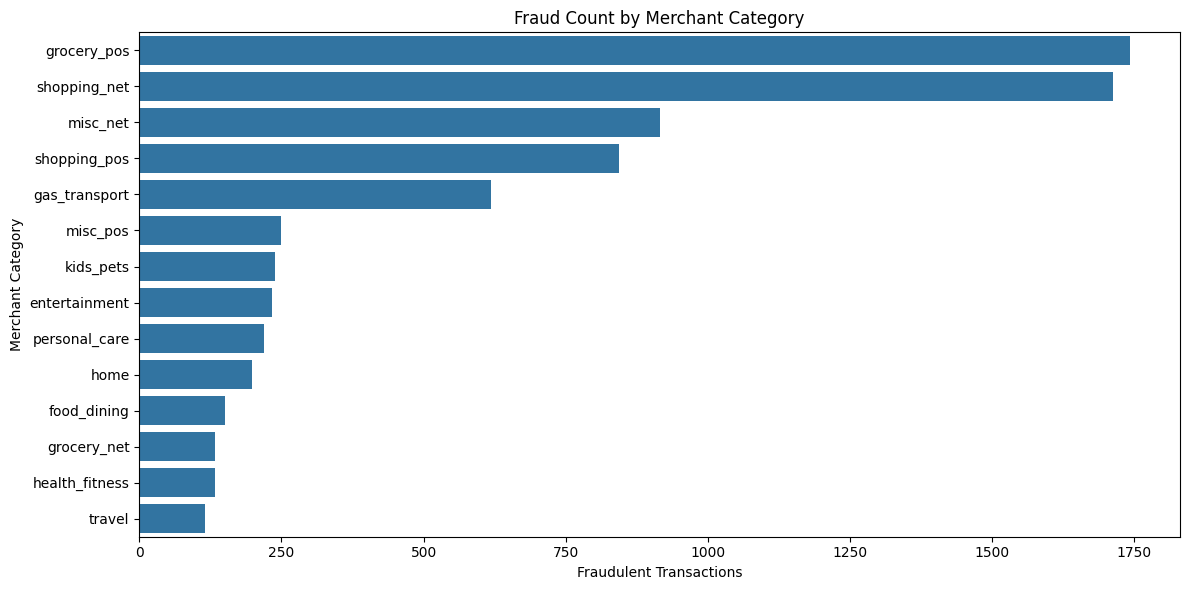

In [14]:
category_fraud = df_final.groupBy("category").agg(
    count(when(col("is_fraud") == 1, True)).alias("fraud_count")
).orderBy("fraud_count", ascending=False)

category_fraud_pd = category_fraud.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=category_fraud_pd, y="category", x="fraud_count")
plt.title("Fraud Count by Merchant Category")
plt.xlabel("Fraudulent Transactions")
plt.ylabel("Merchant Category")
plt.tight_layout()
plt.show()

This bar plot helps identify which merchant categories are most frequently targeted by fraud. Understanding this allows:

- Banks and payment systems to flag high-risk categories

- Businesses to improve fraud detection in vulnerable sectors

- Investigators to prioritize certain industries for further review

The visualization makes patterns obvious and allows for comparisons across all merchant categories at a glance.

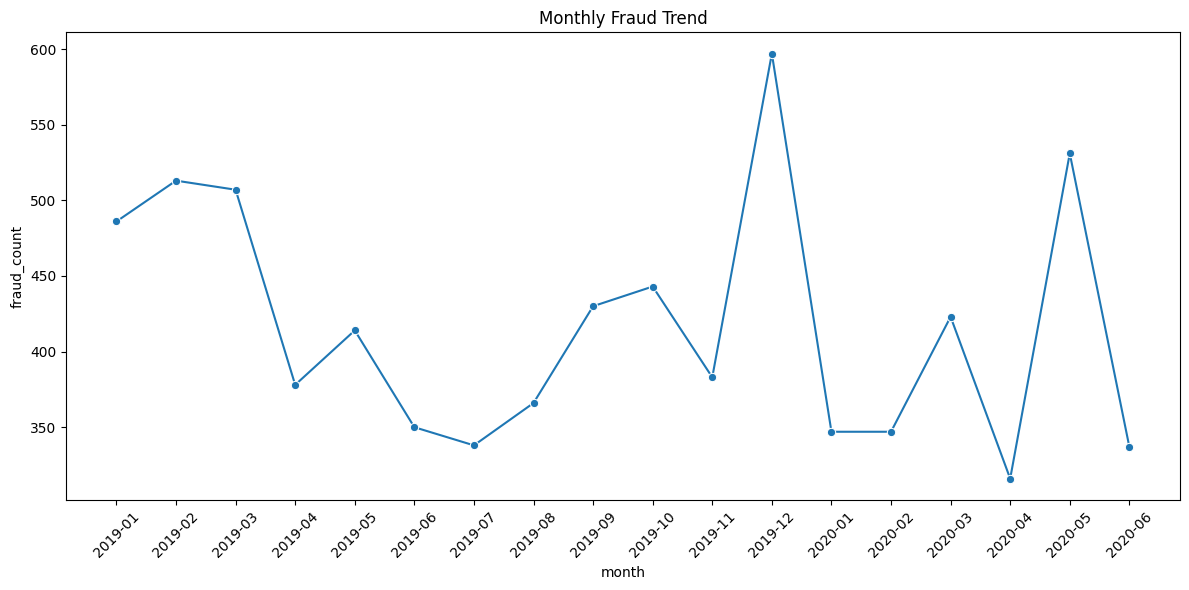

In [15]:
df_with_month = df_final.withColumn("month", date_format(to_timestamp("trans_date_trans_time", "yyyy-MM-dd HH:mm:ss.SSSSSS Z"), "yyyy-MM"))

monthly_fraud = df_with_month.groupBy("month").agg(
    count(when(col("is_fraud") == 1, True)).alias("fraud_count")
).orderBy("month")

monthly_fraud_pd = monthly_fraud.toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_fraud_pd, x="month", y="fraud_count", marker="o")
plt.title("Monthly Fraud Trend")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This line chart helps identify fraud trends over time by showing how many fraudulent transactions occurred each month. It's useful for:

- Spotting spikes or anomalies that may correlate with events or system changes

- Understanding seasonal or temporal patterns in fraud behavior

- Helping fraud teams allocate resources based on peak periods

The clear month-by-month timeline allows for easy tracking and comparison.

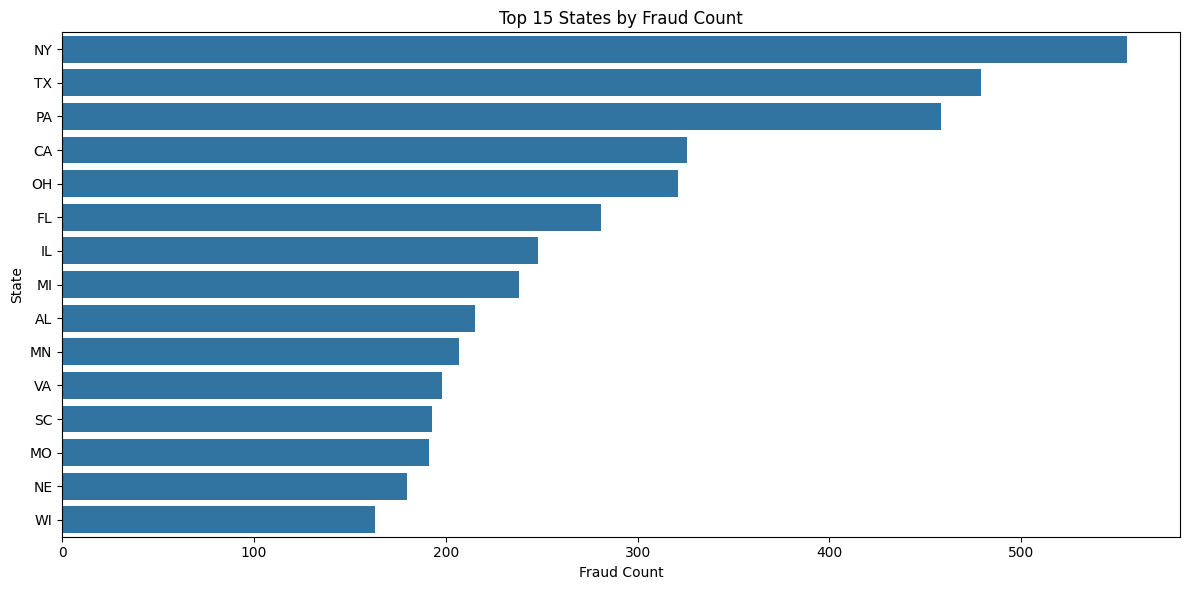

In [16]:
fraud_by_state = df_final.groupBy("state").agg(
    count(when(col("is_fraud") == 1, True)).alias("fraud_count")
).orderBy("fraud_count", ascending=False)

fraud_by_state_pd = fraud_by_state.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_by_state_pd.head(15), x="fraud_count", y="state")
plt.title("Top 15 States by Fraud Count")
plt.xlabel("Fraud Count")
plt.ylabel("State")
plt.tight_layout()
plt.show()

This bar chart highlights geographical patterns in fraud activity, specifically which U.S. states experience the highest volume of fraud. It helps:

- Identify regional hotspots where fraud is more prevalent

- Assist banks and investigators in targeting prevention efforts

- Support risk scoring models that factor in location

By showing the top 15 states, we balance focus and clarity — enough data to see trends, but not too much to overwhelm the viewer.

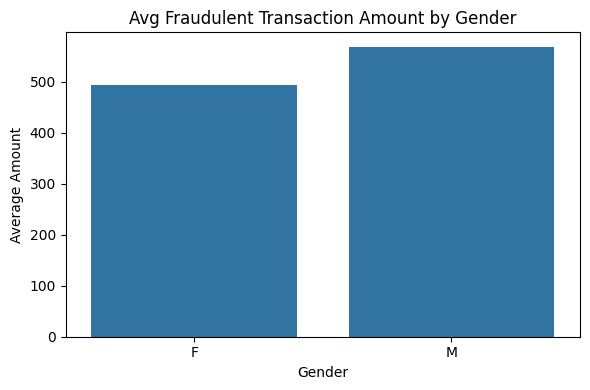

In [17]:
avg_amt_gender = df_final.filter(col("is_fraud") == 1).groupBy("gender").agg(
    avg("amt").alias("avg_amt")
)

avg_amt_gender_pd = avg_amt_gender.toPandas()

plt.figure(figsize=(6, 4))
sns.barplot(data=avg_amt_gender_pd, x="gender", y="avg_amt")
plt.title("Avg Fraudulent Transaction Amount by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Amount")
plt.tight_layout()
plt.show()

This bar plot compares the average size of fraudulent transactions between genders. The purpose is to:

- Understand if fraud patterns differ by gender in terms of transaction value

- Inform profiling strategies for fraud detection systems

- Explore potential behavioral or demographic trends behind fraudulent activity

By focusing only on fraud cases, the chart gives a direct insight into monetary loss patterns based on gender.

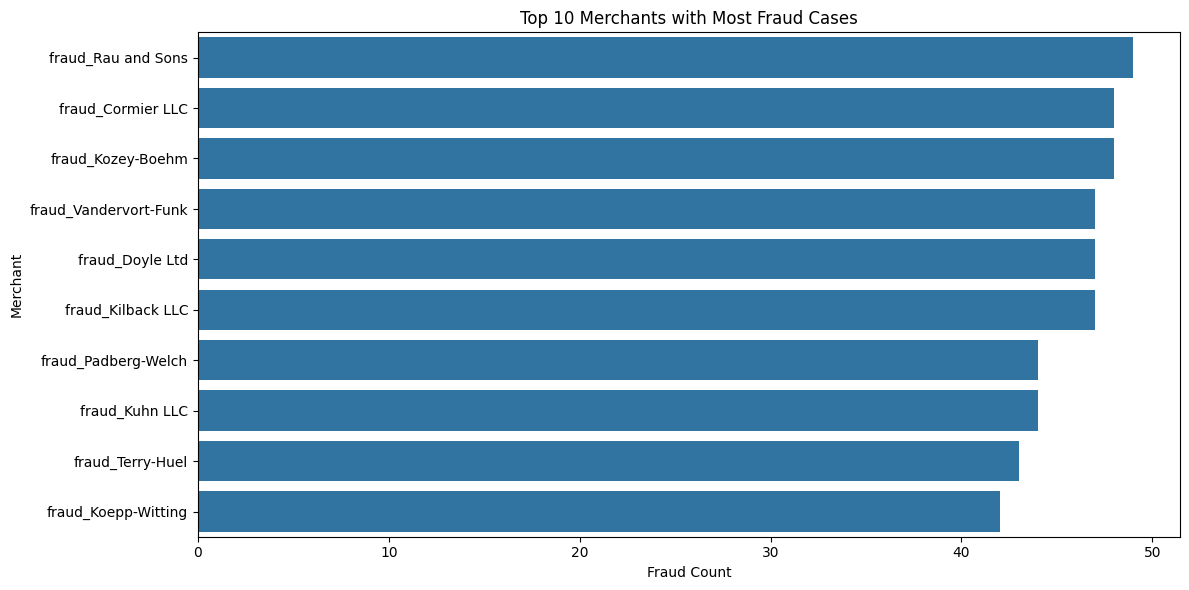

In [18]:
merchant_fraud = df_final.groupBy("merchant").agg(
    count(when(col("is_fraud") == 1, True)).alias("fraud_count")
).orderBy("fraud_count", ascending=False)

merchant_fraud_pd = merchant_fraud.limit(10).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=merchant_fraud_pd, y="merchant", x="fraud_count")
plt.title("Top 10 Merchants with Most Fraud Cases")
plt.xlabel("Fraud Count")
plt.ylabel("Merchant")
plt.tight_layout()
plt.show()

This bar chart identifies which specific merchants are most frequently associated with fraud cases. The goals of this chart are to:

- Detect high-risk merchants that could be compromised or targeted

- Inform merchant monitoring systems and raise red flags

- Help fraud analysts focus investigations on repeat fraud locations

This visualization brings attention to patterns of repeated abuse tied to certain merchant names, useful for both financial institutions and cybersecurity teams.